# HYPERVIEW CHALLANGE

Seeing Beyond the Visible

**Table of contents**

1. [Download the data & requirments](#Download-the-data-and-requirments)



2. [Explore the data](#Explore-the-data)
   
   2.1 [Display hyperspectral band](#Displaying-hyperspectral-band)
   
   2.2 [Display the aggregated spectral curve](#Displaying-the-aggregated-spectral-curve-for-a-field)
   
   2.3 [Check the soil parameters distribution](#Check-the-soil-parameters-distribution)
   
   2.4 [Load the data cube](#Load-the-data)
   
   2.5 [Check the correlation between wavelengths & soil parameters](#Check-the-correlation-between-wavelengths-&-soil-parameters)
   
   2.6 [Check the correlation between soil parameters](#Check-the-correlation-between-the-soil-parameters)



3. [Pre-processing](#Preprocessing)

   3.1 [Spectral curve Derivative](#Spectral-curve-derivative---2nd-Derivative)
   
   3.2 [Narrow bands indices](#Narrow-bands-Indices)
   
   3.3 [Feature selection method](#Feature-selection-method)
   
   3.4 [Features interactions](#Interactions)
   

4. [Modeling](#Modeling)

   4.1 [Stratified kfold splitting](#Stratified-kfold-splitting)
   
   4.2 [Training & predictions](#Training-&-predictions)
   

5. [Post processing](#Post-processing---Level-2-GAM-model)


6. [Create final submission](#Create-final-submission)


## Download the data and requirments

In [ ]:
! pip install -q -r requirements.txt

In [ ]:
# Basic & Built-in 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from scipy.stats import spearmanr
import random
from scipy.stats import gmean
from glob import glob
from scipy.stats import gmean
import pickle
import math
import warnings
warnings.filterwarnings("ignore")


# Sklearn
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor


# GAM
from pygam import LinearGAM, s, f, PoissonGAM,te


# Boosting algorithms
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
with zipfile.ZipFile('./train_data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

with zipfile.ZipFile('./test_data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
# Path to train data directory
tr_path = './train_data'

# hsi paths
hsi_tr = f'{tr_path}/train_data'
hsi_te = '../hyberview/test_data'
hsi_path = f'{tr_path}/train_data/1000.npz'


# Meta data paths
gt_path = f'{tr_path}/train_gt.csv'
wavelength_path = f'{tr_path}/wavelengths.csv'


In [ ]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Explore the data

### Displaying hyperspectral band

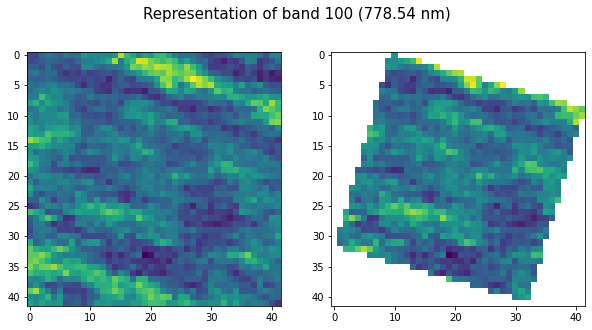

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

### Displaying the aggregated spectral curve for a field

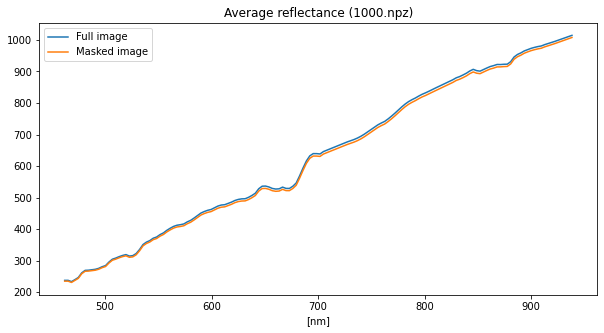

In [ ]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

### Check the soil parameters distribution

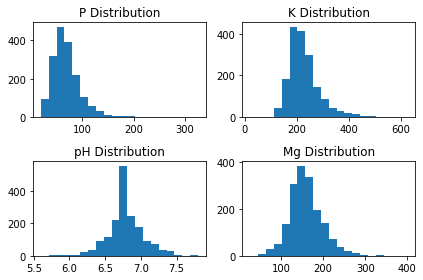

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.hist(gt_df.P, bins=20)
ax0.set_title('P2O5 Distribution')

ax1.hist(gt_df.K, bins=20)
ax1.set_title('K Distribution')


ax2.hist(gt_df.pH, bins=20)
ax2.set_title('pH Distribution')


ax3.hist(gt_df.Mg, bins=20)
ax3.set_title('Mg Distribution')

fig.tight_layout()
plt.show()

In [ ]:
# Check the skewness
gt_df.skew(axis = 0, skipna = True)


sample_index    0.000000
P               2.083224
K               1.567789
Mg              0.733209
pH             -0.011126
dtype: float64

### Load the data
load the data cube into array, then compute stats (mean, min, max, std) for each band. After that stack them into dataframe.

In [ ]:
class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample.data, axis=(1, 2))

In [ ]:
def load_data(directory: str, merge_functions, wv, prefixes):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    hsi_data = None
    for idx, merge_function in enumerate(merge_functions):
      data = []
      filtering = SpectralCurveFiltering(merge_function = merge_function)
      all_files = np.array(
          sorted(
              glob(os.path.join(directory, "*.npz")),
              key=lambda x: int(os.path.basename(x).replace(".npz", "")),
          )
      )
      for file_name in all_files:
          with np.load(file_name) as npz:
              arr = np.ma.MaskedArray(**npz)
                
          arr = filtering(arr)
          data.append(arr)

      data = np.array(data)
      #data = pd.DataFrame(data,columns=[wv], dtype=np.float64)
      data = pd.DataFrame(data,columns=wv, dtype=np.float64)
      data = data.add_prefix(f'{prefixes[idx]}_wv_')
      if hsi_data is None:
        hsi_data = data #pd.DataFrame(data)
      else:
        hsi_data = pd.concat([hsi_data, data], axis=1)

    return hsi_data


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels



In [ ]:
prefixes = ['mean']
merge_functions = [np.mean]
wv = (list(wavelength_df['wavelength']))
X_tr = load_data(hsi_tr, merge_functions, wv, prefixes)

In [ ]:
X_te = load_data(hsi_te, merge_functions, wv, prefixes)

In [ ]:
y = load_gt(gt_path)
y = pd.DataFrame(y, columns=["P", "K", "Mg", "pH"])

In [ ]:
X_tr.head(3)

,mean_wv_462.08,mean_wv_465.27,mean_wv_468.47,mean_wv_471.67,mean_wv_474.86,mean_wv_478.06,mean_wv_481.26,mean_wv_484.45,mean_wv_487.65,mean_wv_490.85,...,mean_wv_909.6,mean_wv_912.8,mean_wv_915.99,mean_wv_919.19,mean_wv_922.39,mean_wv_925.58,mean_wv_928.78,mean_wv_931.98,mean_wv_935.17,mean_wv_938.37
0,450.446281,450.991736,446.842975,454.636364,466.008264,486.834711,499.487603,501.685950,505.041322,509.644628,...,1508.545455,1512.528926,1516.239669,1520.338843,1524.462810,1529.016529,1533.851240,1538.371901,1542.702479,1547.322314
1,556.743802,554.471074,547.652893,556.041322,565.859504,588.231405,599.512397,598.305785,598.330579,600.066116,...,2651.710744,2653.685950,2654.528926,2655.520661,2656.776860,2658.272727,2659.900826,2661.272727,2662.132231,2663.165289
2,424.735537,422.190083,417.214876,425.661157,435.198347,454.661157,465.264463,465.776860,467.768595,470.123967,...,1175.636364,1178.049587,1179.454545,1180.876033,1182.438017,1184.264463,1186.396694,1188.322314,1189.991736,1191.842975


In [ ]:
prefixes = ['std', 'min', 'max', 'median']
merge_functions = [np.std, np.min, np.max, np.median]
wv = (list(wavelength_df['wavelength']))
X_tr_stats = load_data(hsi_tr, merge_functions, wv, prefixes)

X_te_stats = load_data(hsi_te, merge_functions, wv, prefixes)

### Check the correlation between wavelengths & soil parameters

In [ ]:
cols = []
for c in range(len(X_tr.columns)):
  cols.append(X_tr.columns[c])

s_corrs = np.zeros((len(wv),4))

for idx, col in enumerate(cols):
  P_corr, _ = spearmanr(list(np.array(X_tr[col])), list(y['P']))
  K_corr, _ = spearmanr(list(np.array(X_tr[col])), list(y['K']))
  pH_corr, _ = spearmanr(list(np.array(X_tr[col])), list(y['pH']))
  Mg_corr, _ = spearmanr(list(np.array(X_tr[col])), list(y['Mg']))
  s_corrs[idx] = np.array([P_corr,K_corr,pH_corr,Mg_corr])

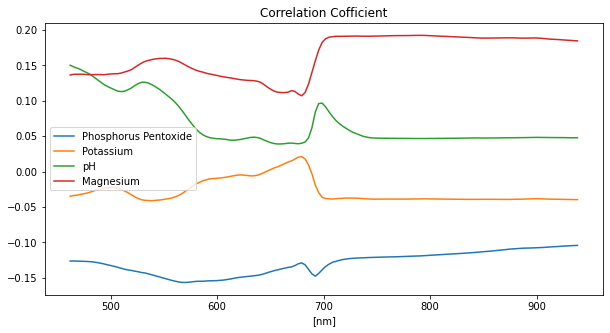

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.plot(wavelength_df['wavelength'], s_corrs[:,0], label='Phosphorus Pentoxide')
plt.plot(wavelength_df['wavelength'],  s_corrs[:,1], label='Potassium')
plt.plot(wavelength_df['wavelength'],  s_corrs[:,2], label='pH')
plt.plot(wavelength_df['wavelength'],  s_corrs[:,3], label='Magnesium')


plt.xlabel('[nm]')
plt.legend()
plt.title(f'Correlation Cofficient')
plt.show()

### Check the correlation between the soil parameters

In [ ]:
y.corr(method='spearman')

,P,K,Mg,pH
P,1.000000,0.380047,-0.146342,0.137364
K,0.380047,1.000000,0.252113,0.128206
Mg,-0.146342,0.252113,1.000000,-0.013374
pH,0.137364,0.128206,-0.013374,1.000000


## Preprocessing

### Spectral curve derivative - 2nd Derivative

Compute the 2nd deriviative of spectral curve, and use for P, K predictions

In [ ]:
wvls = np.array(wavelength_df['wavelength'])
wvls.shape

d1  = wvls[1:] 
d2 = wvls[:-1]
cols = []
for i, wv in enumerate(wvls[1:]):
    col = f'derv_{wv}_{d2[i]}'
    cols.append(col)
    
data = []
for i in range(X_tr.shape[0]):
    a = np.array(X_tr.loc[i])
    da1 = a[1:] - a[0:-1]
    da2 = da1[1:] - da1[0:-1]
    arr = da2/3.2
    data.append(arr)
    
    
data = np.array(data)
X_tr_de = pd.DataFrame(data,columns=cols[1:], dtype=np.float64)

data = []
for i in range(X_te.shape[0]):
    a = np.array(X_te.loc[i])
    da1 = a[1:] - a[0:-1]
    da2 = da1[1:] - da1[0:-1]
    arr = da2/3.2
    data.append(arr)
    
    
data = np.array(data)
X_te_de = pd.DataFrame(data, columns=cols[1:], dtype=np.float64)

### Narrow bands Indices
Compute all avaialble indices between the bands

In [ ]:
# Indices of important features
def NBI(df, features):
  X_indices = None
  names = []
  for col1 in features:
    indices = []
    for col2 in features:
      if col1 !=col2:
        name = f'Index_{col1}_{col2}'

        index = (np.array(df[col2]) - np.array(df[col1])) / (np.array(df[col2]) + np.array(df[col1]))
        names.append(name)

        indices.append(pd.DataFrame(index, columns=[name]))

    X_new_indices = pd.concat(indices, axis=1)

    if X_indices is None:
      X_indices = X_new_indices
    else:
      X_indices = pd.concat([X_indices, X_new_indices] , axis=1, ignore_index=False)

  return  X_indices

In [ ]:
# All possible band combinations
features = X_tr.columns

X_tr_indices = NBI(X_tr, features)
X_te_indices = NBI(X_te, features)

In [ ]:
# Stack the narrow band indices with the copmuted stats for each band
X_tr = pd.concat([X_tr, X_tr_indices] , axis=1, ignore_index=False)
X_te = pd.concat([X_te, X_te_indices] , axis=1, ignore_index=False)


X_tr = pd.concat([X_tr, X_tr_stats] , axis=1, ignore_index=False)
X_te = pd.concat([X_te, X_te_stats] , axis=1, ignore_index=False)

print(X_tr.shape)
print(X_te.shape)

(1732, 22500)
(1154, 22500)


### Feature selection method

Use Recursive Feature Elimination method with random forest base to select the most importan features.

In [ ]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=2022), n_features_to_select=500, step=0.40)
model = RandomForestRegressor(n_estimators=100, random_state=2022)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

pipeline.fit(X_tr, y['P'])

cols = list(X_tr.columns)
P_selected_features = []
for idx, col in enumerate(cols):
    if rfe.support_[idx]:
        P_selected_features.append(col)
        

with open('./P_selected_features.pkl', 'wb') as f:
    pickle.dump(P_selected_features, f)
    
    

In [ ]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=2022), n_features_to_select=500, step=0.40)
model = RandomForestRegressor(n_estimators=100, random_state=2022)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

pipeline.fit(X_tr, y['K'])

cols = list(X_tr.columns)
K_selected_features = []
for idx, col in enumerate(cols):
    if rfe.support_[idx]:
        K_selected_features.append(col)
        
with open('./K_selected_features.pkl', 'wb') as f:
    pickle.dump(K_selected_features, f)
    
        

In [ ]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=2022), n_features_to_select=500, step=0.40)
model = RandomForestRegressor(n_estimators=100, random_state=2022)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

pipeline.fit(X_tr, y['Mg'])

cols = list(X_tr.columns)
Mg_selected_features = []
for idx, col in enumerate(cols):
    if rfe.support_[idx]:
        Mg_selected_features.append(col)
        
with open('./Mg_selected_features.pkl', 'wb') as f:
    pickle.dump(Mg_selected_features, f)


In [ ]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=2022), n_features_to_select=500, step=0.40)
model = RandomForestRegressor(n_estimators=100, random_state=2022)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

pipeline.fit(X_tr, y['pH'])

cols = list(X_tr.columns)
pH_selected_features = []
for idx, col in enumerate(cols):
    if rfe.support_[idx]:
        pH_selected_features.append(col)
        
        
with open('./pH_selected_features.pkl', 'wb') as f:
    pickle.dump(pH_selected_features, f)


In [ ]:
P_X_tr = X_tr[P_selected_features]
P_X_te = X_te[P_selected_features]

K_X_tr = X_tr[K_selected_features]
K_X_te = X_te[K_selected_features]

Mg_X_tr = X_tr[Mg_selected_features]
Mg_X_te = X_te[Mg_selected_features]

pH_X_tr = X_tr[pH_selected_features]
pH_X_te = X_te[pH_selected_features]

In [ ]:
P_X_tr.to_csv("./P_X_tr.csv", index =False)
P_X_te.to_csv("./P_X_te.csv", index =False)

K_X_tr.to_csv("./K_X_tr.csv", index =False)
K_X_te.to_csv("./K_X_te.csv", index =False)

Mg_X_tr.to_csv("./Mg_X_tr.csv", index =False)
Mg_X_te.to_csv("./Mg_X_te.csv", index =False)

pH_X_tr.to_csv("./pH_X_tr.csv", index =False)
pH_X_te.to_csv("./pH_X_te.csv", index =False)

### Interactions
Compute the interaction between the top 10 important features, then add them to most important features

In [ ]:
def interactions(df, features):
    X_interact = None
    names = []
    p_columns = []
    for col1 in features:
        interact = []
        p_columns.append(col1)

        for col2 in features:
            if col2 not in p_columns:
                
                name = f'{col1}_multi_{col2}'
                name2 =  f'{col1}_div_{col2}'
                multi = np.array(df[col2]) * np.array(df[col1])
                names.append(name)
                interact.append(pd.DataFrame(multi, columns=[name]))


                divi = np.array(df[col2]) / np.array(df[col1] + 1e-6)
                names.append(name2)
                interact.append(pd.DataFrame(divi, columns=[name2]))
                
        if len(p_columns) != len(features):
            X_new_interact = pd.concat(interact, axis=1)

            if X_interact is None:
                X_interact = X_new_interact
            else:
                X_interact = pd.concat([X_interact, X_new_interact] , axis=1, ignore_index=False)

    return  X_interact

In [ ]:
# Interaction between the top 10 important features for phosphorus pentoxide
features = P_X_tr.columns[:10]

X_tr_intrs = interactions(P_X_tr[features], features)
X_te_intrs = interactions(P_X_te[features], features)

P_X_tr = pd.concat([P_X_tr, X_tr_intrs] , axis=1, ignore_index=False)
P_X_te = pd.concat([P_X_te, X_te_intrs] , axis=1, ignore_index=False)

print(P_X_tr.shape)
print(P_X_te.shape)

(1732, 590)
(1154, 590)


In [ ]:
# Interaction between the top 10 important features for potassium 

features = K_X_tr.columns[:10]

X_tr_intrs = interactions(K_X_tr[features], features)
X_te_intrs = interactions(K_X_te[features], features)

K_X_tr = pd.concat([K_X_tr, X_tr_intrs] , axis=1, ignore_index=False)
K_X_te = pd.concat([K_X_te, X_te_intrs] , axis=1, ignore_index=False)

print(K_X_tr.shape)
print(K_X_te.shape)

(1732, 590)
(1154, 590)


In [ ]:
# Interaction between the top 10 important features for magnesium  
features = Mg_X_tr.columns[:10]

X_tr_intrs = interactions(Mg_X_tr[features], features)
X_te_intrs = interactions(Mg_X_te[features], features)

Mg_X_tr = pd.concat([Mg_X_tr, X_tr_intrs] , axis=1, ignore_index=False)
Mg_X_te = pd.concat([Mg_X_te, X_te_intrs] , axis=1, ignore_index=False)

print(Mg_X_tr.shape)
print(Mg_X_te.shape)

(1732, 590)
(1154, 590)


In [ ]:
# Interaction between the top 10 important features for pH 
features = pH_X_tr.columns[:10]

X_tr_intrs = interactions(pH_X_tr[features], features)
X_te_intrs = interactions(pH_X_te[features], features)

pH_X_tr = pd.concat([pH_X_tr, X_tr_intrs] , axis=1, ignore_index=False)
pH_X_te = pd.concat([pH_X_te, X_te_intrs] , axis=1, ignore_index=False)

print(pH_X_tr.shape)
print(pH_X_te.shape)

(1732, 590)
(1154, 590)


In [ ]:
# We will use 2nd derivative of spectal curve just for P & K
P_X_tr = pd.concat([P_X_tr, X_tr_de] , axis=1, ignore_index=False)
P_X_te = pd.concat([P_X_te, X_te_de] , axis=1, ignore_index=False)

K_X_tr = pd.concat([K_X_tr, X_tr_de] , axis=1, ignore_index=False)
K_X_te = pd.concat([K_X_te, X_te_de] , axis=1, ignore_index=False)

## Modeling

### Stratified kfold splitting

The soil parameters do not have normal distribution, and there is a skewness. Therfore, the data splitted using StratifiedKFold into 10 folds.

In [ ]:
P_data = pd.concat([P_X_tr, y['P']], axis=1).reset_index(drop=True)
K_data = pd.concat([K_X_tr, y['K']], axis=1).reset_index(drop=True)
Mg_data = pd.concat([Mg_X_tr, y['Mg']], axis=1).reset_index(drop=True)
pH_data = pd.concat([pH_X_tr, y['pH']], axis=1).reset_index(drop=True)

In [ ]:
def skf_split(data_df, target):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2022)
    num_splits = 10
    num_bins = math.floor(len(data_df) / num_splits)  # num of bins to be created
    bins_on = data_df[target]  # variable to be used for stratification
    qc = pd.cut(bins_on.tolist(), num_bins)  # divides data in bins
    data_df['bins'] = qc.codes
    
    val_index = []
    X_train, X_val = [], []
    Y_train, Y_val = [], []
    for idx , (train, val) in enumerate(skf.split(data_df,data_df['bins'])):
        x_train, x_val, y_train, y_val = data_df.iloc[train], data_df.iloc[val], data_df[target].iloc[train], data_df[target].iloc[val]
        x_train = x_train.drop(['bins', target], axis=1)
        x_val = x_val.drop(['bins', target], axis=1)
        
        val_index.append(val)
        X_train.append(x_train)
        Y_train.append(y_train)
        
        X_val.append(x_val)
        Y_val.append(y_val)
    
    return X_train, X_val, Y_train, Y_val, val_index

In [ ]:
X_P_tr,X_P_val, y_P_tr, y_P_val, P_val_index = skf_split(P_data, 'P')
X_K_tr,X_K_val, y_K_tr, y_K_val, K_val_index = skf_split(K_data, 'K')
X_Mg_tr,X_Mg_val, y_Mg_tr, y_Mg_val, Mg_val_index = skf_split(Mg_data, 'Mg')
X_pH_tr,X_pH_val, y_pH_tr, y_pH_val, pH_val_index = skf_split(pH_data, 'pH')

### Training & predictions

In [ ]:
# Evaluation metric
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
      self.mean = np.mean(y_train, axis=0)
      self.classes_count = 1
      return self

    def predict(self, X_test: np.ndarray):
      return np.full((len(X_test), self.classes_count), self.mean)

In [ ]:
# Create a bag of models / 5 models for each fold
def regressor(x_train, y_train, x_val, y_val, X_test):
    rf_regressor = RandomForestRegressor(random_state=2022, criterion='squared_error', n_estimators=700)
    rf_regressor.fit(x_train,y_train)
    rf_val_preds =  rf_regressor.predict(x_val)
    rf_te_preds = rf_regressor.predict(X_test)

    
    cat_regressor = CatBoostRegressor(n_estimators=3000,learning_rate=0.01,logging_level='Silent',random_state=2022, early_stopping_rounds=300)
    cat_regressor.fit(x_train,y_train)
    cat_val_preds =  cat_regressor.predict(x_val)
    cat_te_preds = cat_regressor.predict(X_test)

    
    
    lgbm_regressor = LGBMRegressor(learning_rate=0.01, n_estimators=3000,deterministic=True,random_state=2022, n_jobs=- 1) #,subsample=0.65,subsample_freq=20, colsample_bytree=0.65,
    lgbm_regressor.fit(x_train,y_train)
    lgbm_val_preds =  lgbm_regressor.predict(x_val)
    lgbm_te_preds = lgbm_regressor.predict(X_test)

    
    xgbm_regressor =XGBRegressor(n_estimators = 2000,learning_rate = 0.01,seed=2022,random_state = 2022)
    xgbm_regressor.fit(x_train,y_train)
    xgbm_val_preds =  xgbm_regressor.predict(x_val)
    xgbm_te_preds = xgbm_regressor.predict(X_test)

    
    et_regressor = ExtraTreesRegressor(n_estimators=700,criterion = "squared_error",
                                       random_state=2022) 
    et_regressor.fit(x_train,y_train)
    et_val_preds =  et_regressor.predict(x_val)
    et_te_preds = et_regressor.predict(X_test)

    

    # Predictions
    baseline_reg = BaselineRegressor()
    baseline_reg = baseline_reg.fit(x_train, y_train)
    
    score, te_preds, train_preds = EvaluationMetric(baseline_reg, x_val, y_val, rf_val_preds, cat_val_preds,lgbm_val_preds, xgbm_val_preds,et_val_preds,
                                       rf_te_preds, cat_te_preds, lgbm_te_preds, xgbm_te_preds, et_te_preds)


    return score, te_preds , train_preds

In [ ]:
# Evaluate each model in the bag then assiagn weights to them based on their performance on the validation dataset
# then ensmbele their results 'weighted ensemble models'

def EvaluationMetric(baseline_reg, x_val, y_val, rf_val_preds, cat_val_preds, lgbm_val_preds, xgbm_val_preds, et_val_preds,
                     rf_te_preds, cat_te_preds, lgbm_te_preds, xgbm_te_preds, et_te_preds):
    
    baseline_predictions = baseline_reg.predict(x_val)
    baseline_predictions = baseline_predictions.squeeze()
    baselines = np.mean((y_val - baseline_predictions) ** 2, axis=0)
    
    # Calculate MSE
    best_score = np.inf
    for i in range(5000):
        weights = np.random.dirichlet(np.ones(5),size=1)
        a = weights[0][0]
        b = weights[0][1]
        c = weights[0][2]
        d = weights[0][3]
        e = weights[0][4]
        
        val_preds = (a * rf_val_preds) + (b * cat_val_preds) + (c * lgbm_val_preds) + (d * xgbm_val_preds) + (e * et_val_preds)
        mse = np.mean((y_val - val_preds) ** 2, axis=0)
        score = mse / baselines
        
        if score < best_score:
            best_score = score
            best_a = a
            best_b = b
            best_c = c
            best_d = d
            best_e = e
    val_preds = (best_a * rf_val_preds) + (best_b * cat_val_preds) + (best_c * lgbm_val_preds) + (best_d * xgbm_val_preds) + (best_e * et_val_preds)
    te_preds = (best_a * rf_te_preds) + (best_b * cat_te_preds) + (best_c * lgbm_te_preds) + (best_d * xgbm_te_preds) + (best_e * et_te_preds)
    

    return best_score, te_preds, val_preds

In [ ]:
np.random.seed(2022)

final_scores = []
final_predictions = []
train_preds = np.zeros((X_tr.shape[0],4)) 

for i, fold in enumerate(range(10)):
    print(f'######### FOLD {i+1} / 10')
    scores = []
    preds = np.zeros((X_te.shape[0],4))

    # Predict P 
    x_train, x_val, y_train,  y_val = X_P_tr[fold], X_P_val[fold], y_P_tr[fold], y_P_val[fold]
    score, P_preds , P_train_preds = regressor(x_train, y_train, x_val, y_val, P_X_te)
    scores.append(score)
    print(f'P Score: {score}')
    train_preds[P_val_index[fold],0] = P_train_preds
    preds[:,0] = P_preds
    

    # Predict k
    x_train, x_val, y_train,  y_val = X_K_tr[fold], X_K_val[fold], y_K_tr[fold], y_K_val[fold]
    score,  k_preds, k_train_preds = regressor(x_train, y_train, x_val, y_val, K_X_te)
    scores.append(score)
    print(f'K Score: {score}')
    train_preds[K_val_index[fold],1] = k_train_preds
    preds[:,1] =k_preds
    

    # Predict Mg
    x_train, x_val, y_train,  y_val = X_Mg_tr[fold], X_Mg_val[fold], y_Mg_tr[fold], y_Mg_val[fold]
    score, Mg_preds, Mg_train_preds = regressor(x_train, y_train, x_val, y_val, Mg_X_te)
    scores.append(score)
    print(f'Mg Score: {score}')
    train_preds[Mg_val_index[fold],2] = Mg_train_preds
    preds[:,2] = Mg_preds


    # Predict pH
    x_train, x_val, y_train,  y_val = X_pH_tr[fold], X_pH_val[fold], y_pH_tr[fold], y_pH_val[fold]
    score, pH_preds, pH_train_preds = regressor(x_train, y_train, x_val, y_val, pH_X_te)
    scores.append(score)
    print(f'pH Score: {score}')
    train_preds[pH_val_index[fold],3] = pH_train_preds
    preds[:,3] = pH_preds

    final_score = np.mean(scores)
    print(f'Overall score: {final_score} ')

    final_scores.append(final_score)

    final_predictions.append(preds)


print('mean scores: {} '.format(np.mean(final_scores)))

######### FOLD 1 / 10
P Score: 0.9569969669011275
K Score: 0.787548908235505
Mg Score: 0.7658640110231868


In [ ]:
train_preds = pd.DataFrame(data = train_preds, columns=["P", "K", "Mg", "pH"])
train_preds.to_csv("./train_preds.csv", index_label="sample_index")

f_te_predictions = gmean(final_predictions, axis=0)
f_te_predictions = pd.DataFrame(data = f_te_predictions, columns=["P", "K", "Mg", "pH"])
f_te_predictions.to_csv("./f_te_predictions.csv", index_label="sample_index")

## Post processing - Level 2 GAM model
The soil parameters are correlated with each other. So, GAM model used as 2-level model to take intpo cosideration any correlation between them.

In [ ]:
X = np.array(train_preds[['P','K','Mg','pH']])
X_te = np.array(f_te_predictions[['P','K','Mg','pH']])

y_p = np.array(y['P'])
y_K = np.array(y['K'])
y_Mg = np.array(y['Mg'])
y_pH = np.array(y['pH'])

In [ ]:
def EvaluationMetric(baseline_reg, x_val, y_val, val_preds):
    baseline_predictions = baseline_reg.predict(x_val)
    baseline_predictions = baseline_predictions.squeeze()
    baselines = np.mean((y_val - baseline_predictions) ** 2, axis=0)
    
    mse = np.mean((y_val - val_preds) ** 2, axis=0)
    score = mse / baselines

    return score

In [ ]:
def regressor(x_train, y_train, x_val, y_val, X_test):
    
    gam_p = LinearGAM(s(0) + s(1) +s(2) + s(3) + te(0, 1)+ te(0, 2)+ te(0, 3)+ te(1, 2) + te(1, 3) + te(2, 3))
    gam_p.gridsearch(x_train, y_train)
    val_preds = gam_p.predict(x_val)
    
    # Predictions
    baseline_reg = BaselineRegressor()
    baseline_reg = baseline_reg.fit(x_train, y_train)
    
    score = EvaluationMetric(baseline_reg, x_val, y_val, val_preds)
    te_preds =  gam_p.predict(X_test)

    return score, te_preds

In [ ]:
from pygam import LinearGAM, s, f ,te

In [ ]:
np.random.seed(2022)

kf = KFold(n_splits =5,shuffle=True,random_state=2022)

final_scores = []
final_predictions = []


for i,(tr_index, val_index) in enumerate(kf.split(X, y_p)):
    print(f'######### FOLD {i+1} / {kf.n_splits}')
    scores = []
    preds = np.zeros((X_te.shape[0],4))
    
    x_train, y_train, x_val, y_val = X[tr_index], y_p[tr_index], X[val_index], y_p[val_index]
    score, P_preds = regressor(x_train, y_train, x_val, y_val, X_te)
    scores.append(score)
    print(f'P Score: {score}')
    preds[:,0] = P_preds
    
    x_train, y_train, x_val, y_val = X[tr_index], y_K[tr_index], X[val_index], y_K[val_index]
    score, k_preds = regressor(x_train, y_train, x_val, y_val, X_te)
    scores.append(score)
    print(f'k Score: {score}')
    preds[:,1] = k_preds
    
 
    x_train, y_train, x_val, y_val = X[tr_index], y_Mg[tr_index], X[val_index], y_Mg[val_index]
    score, Mg_preds = regressor(x_train, y_train, x_val, y_val, X_te)
    scores.append(score)
    print(f'Mg Score: {score}')
    preds[:,2] = Mg_preds
    
 
    x_train, y_train, x_val, y_val = X[tr_index], y_pH[tr_index], X[val_index], y_pH[val_index]
    score, pH_preds = regressor(x_train, y_train, x_val, y_val, X_te)
    scores.append(score)
    print(f'pH Score: {score}')
    preds[:,3] = pH_preds
    
    
    final_score = np.mean(scores)
    print(f'Overall score: {final_score} ')

    final_scores.append(final_score)
    final_predictions.append(preds)


print('mean scores: {} '.format(np.mean(final_scores)))   

## Create final submission

In [ ]:
final_test_predictions = gmean(final_predictions, axis=0)

submission = pd.DataFrame(data = final_test_predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("./final_submission.csv", index_label="sample_index")